## Aufgabe 12.3 – Regressionsmodell für Endgewicht

Ziel dieser Aufgabe ist es, ein lineares Regressionsmodell zur Vorhersage des Endgewichts (`final_weight`) basierend auf Flaschensensordaten zu erstellen.  
Dazu werden verschiedene Feature-Kombinationen getestet, die Modelle evaluiert (Training/Test-MSE), und schließlich eine Prognose für neue Flaschen auf Basis von `X.csv` durchgeführt.

### Verwendete Bibliotheken
- `pandas` für Datenmanipulation
- `numpy` für numerische Operationen
- `matplotlib` und `seaborn` für Datenvisualisierung
- `scikit-learn` (*LinearRegression*, *train_test_split*, *mean_squared_error*) für lineare Regression, Datenaufteilung und Metriken 

### Vorbereitung

Import der benötigten Bibliotheken, Festlegen des Projektpfads und Einlesen der aggregierten Daten (`data.csv`), die bereits über `transform.py` bereinigt wurden.

In [50]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Projektstruktur
project_path = os.path.abspath(os.path.join(".."))
data_path = os.path.join(project_path, "database", "data.csv")
x_csv_path = os.path.join(project_path, "regression", "X.csv")
prediction_output_path = os.path.join(project_path, "regression", "reg_Czermak-Eckstein-Neuner.csv")

### Datenanalyse & -bereinigung

Einlesen der Flaschendaten, Entfernen fehlerhafter Einträge (`final_weight = 0`).

Anschließend wird ein Überblick über die potenziellen Features und deren Verteilung (via `pairplot`) gegeben.

,vibration_index_red,vibration_index_green,vibration_index_blue,fill_level_red,fill_level_green,fill_level_blue,temperature_red,temperature_green,temperature_blue,final_weight
0,0.000000,66.925175,0.000000,0.000000,71.626434,0.000000,29.970807,28.938742,30.804508,56.453902
1,0.000000,61.914183,212.907583,0.000000,66.949427,252.071342,31.144326,29.145823,31.832697,57.027849
2,260.530238,64.551173,213.027567,607.212216,62.167275,239.192723,29.698757,29.807046,30.125917,57.113693
3,255.123575,68.544872,205.247171,591.005966,57.353258,226.602061,30.559746,31.403949,30.533312,56.625979
4,254.269852,62.438744,210.381290,574.403587,52.775501,213.233282,28.455239,29.649357,31.130350,56.575806


<class 'pandas.core.frame.DataFrame'>
Index: 240 entries, 0 to 239
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   bottle                 240 non-null    int64  
 1   fill_level_red         240 non-null    float64
 2   vibration_index_red    240 non-null    float64
 3   fill_level_blue        240 non-null    float64
 4   vibration_index_blue   240 non-null    float64
 5   fill_level_green       240 non-null    float64
 6   vibration_index_green  240 non-null    float64
 7   final_weight           240 non-null    float64
 8   drop_oscillation       240 non-null    object 
 9   is_cracked             240 non-null    object 
 10  temperature_red        240 non-null    float64
 11  temperature_green      240 non-null    float64
 12  temperature_blue       240 non-null    float64
dtypes: float64(10), int64(1), object(2)
memory usage: 26.2+ KB
None


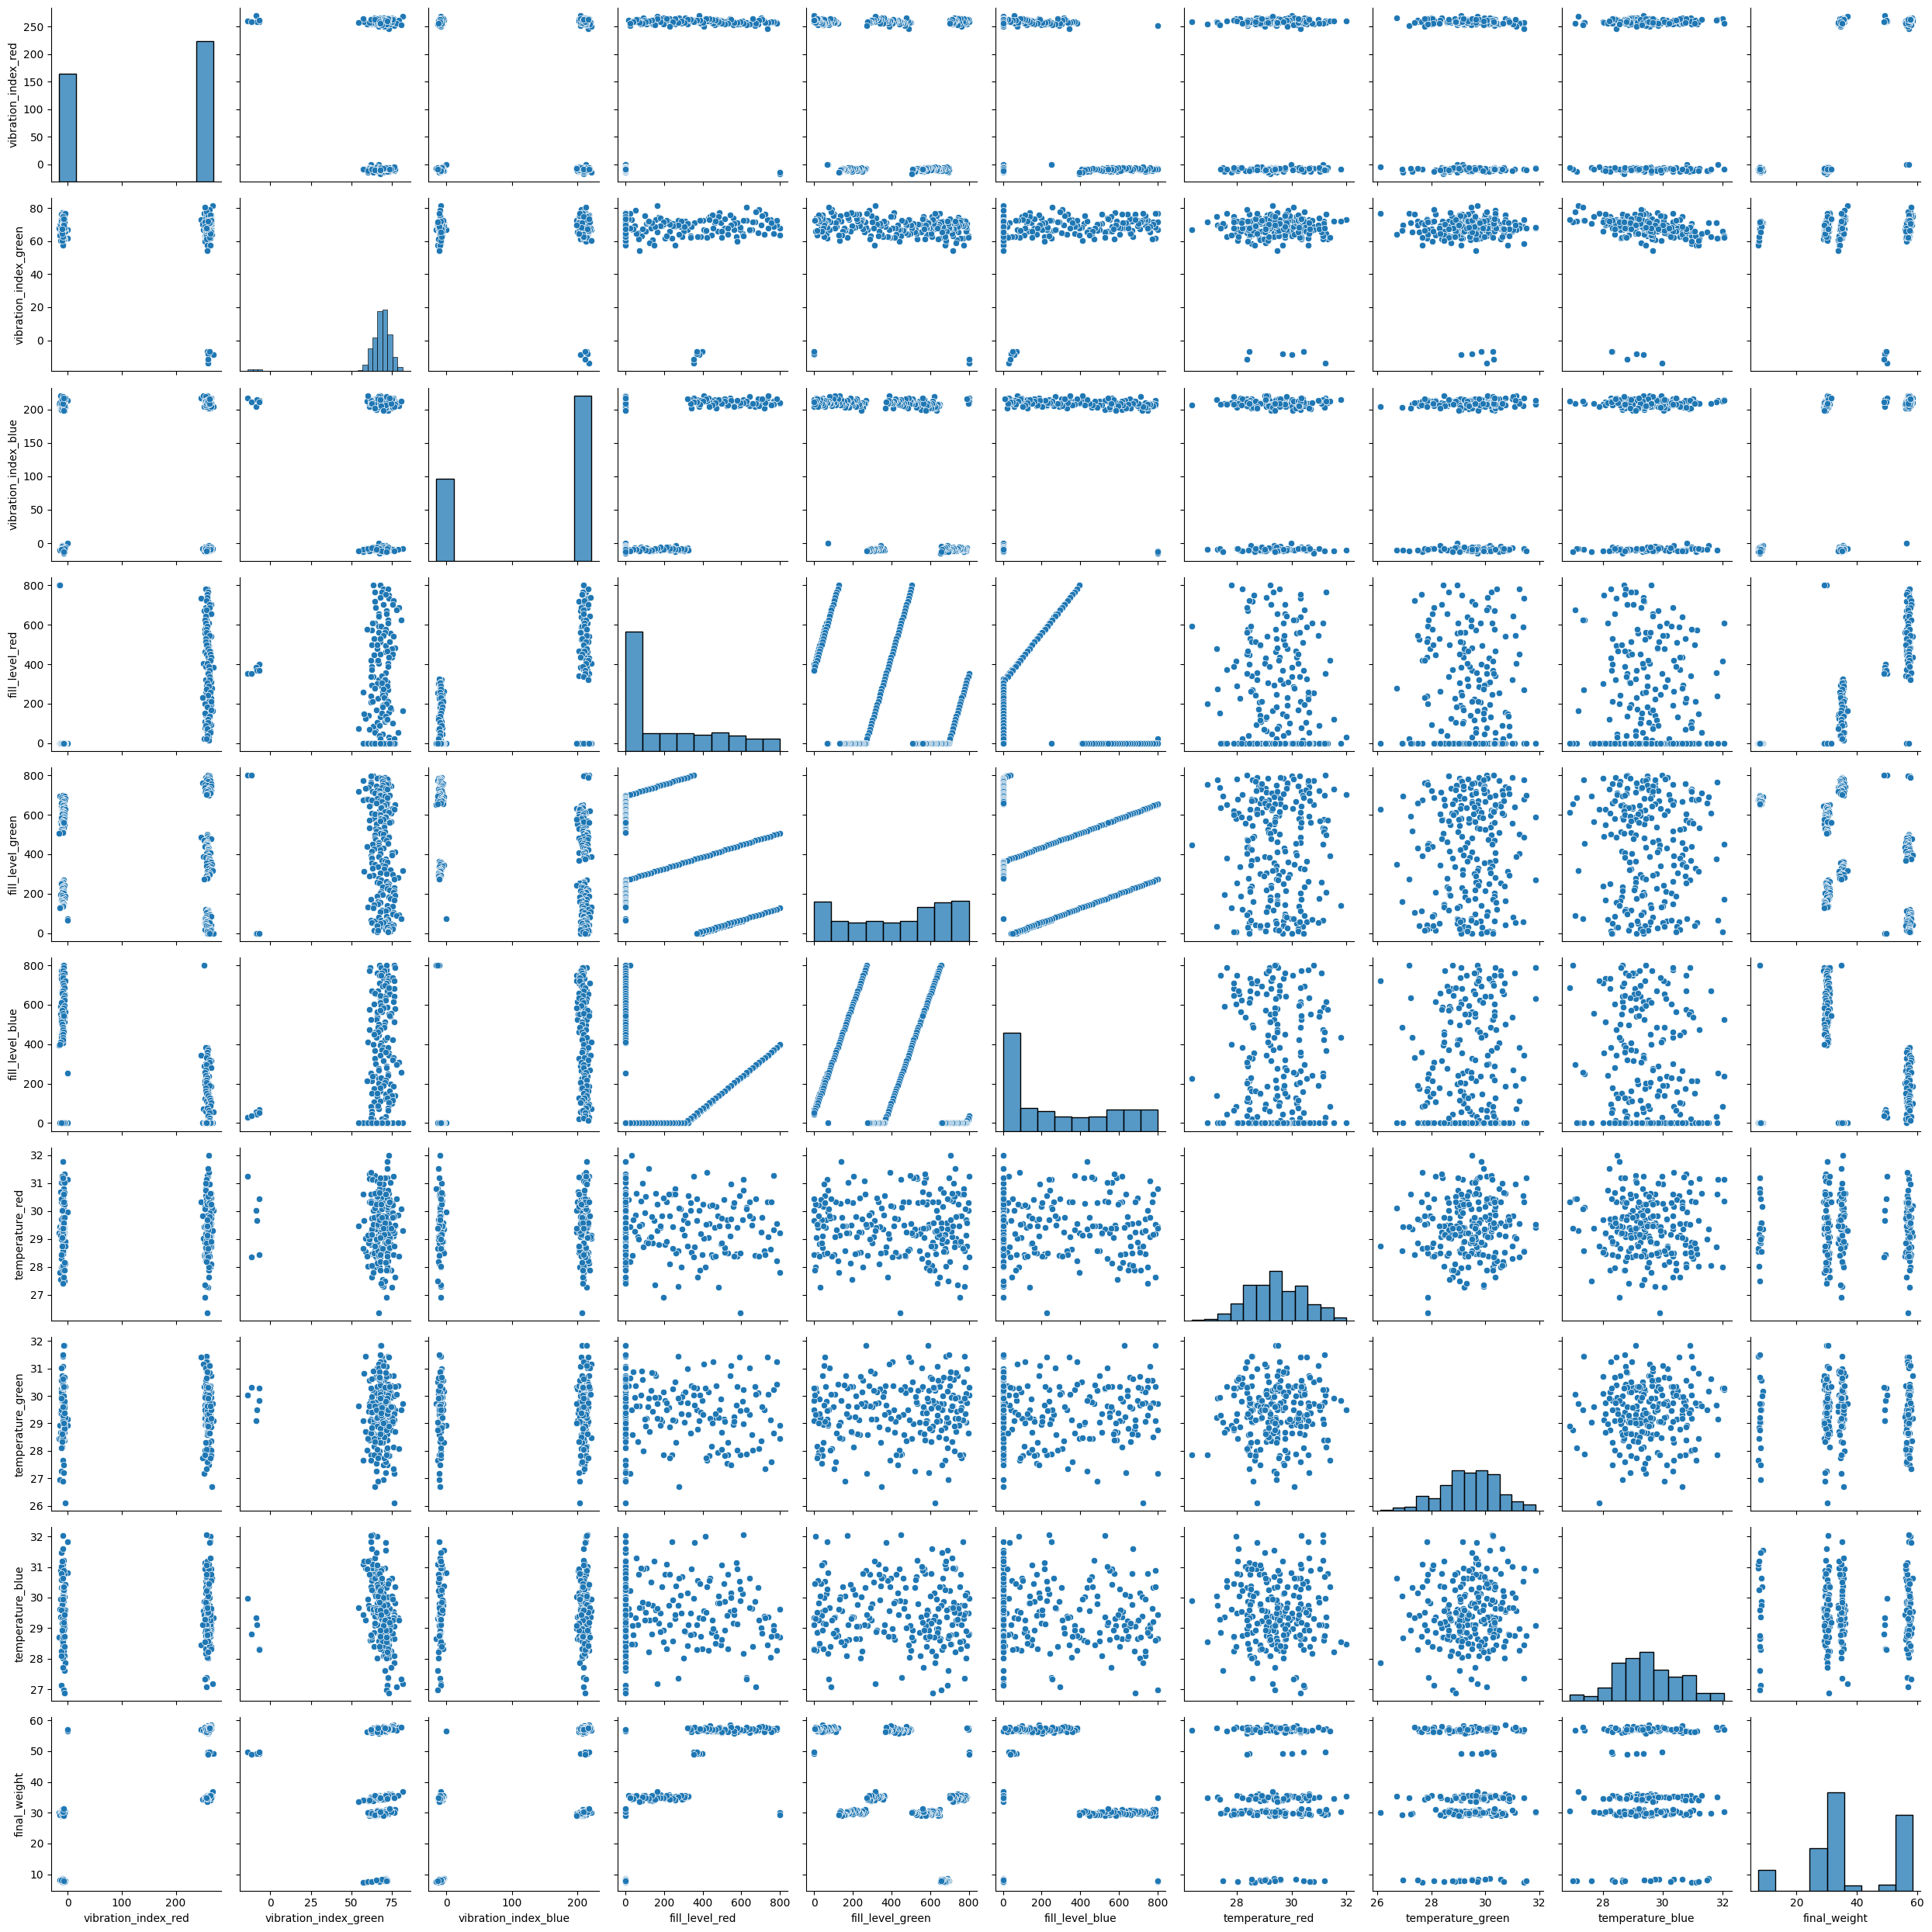

In [51]:
# Daten laden
df = pd.read_csv(data_path)

# Unbrauchbare Flaschen (final_weight == 0) filtern
df = df[df["final_weight"] > 0]

# Zielvariable
y = df["final_weight"]

# Definierte Features (auch in "X.csv" enthalten)
features_available = [
    'vibration_index_red', 'vibration_index_green', 'vibration_index_blue',
    'fill_level_red', 'fill_level_green', 'fill_level_blue',
    'temperature_red', 'temperature_green', 'temperature_blue'
]

# Vorschau und strukturelle Infos
display(df[features_available + ["final_weight"]].head())
print(df.info())

# Visualisierung der Beziehungen
sns.pairplot(df[features_available + ["final_weight"]])
plt.tight_layout()
plt.show()


> Im Pairplot zeigen weder die Temperatur- noch die Füllstandswerte einen klaren linearen Zusammenhang mit dem finalen Gewicht.  
> Auch die Vibrationsdaten weisen visuell keine offensichtliche Korrelation auf.  
> Dennoch liefern gerade die Vibrationsdaten die besten Ergebnisse im Regressionsmodell - was sich später noch zeigen wird.  
> Dies zeigt, dass visuelle Analyse allein nicht ausreicht, um Prädiktionskraft zu beurteilen.  
> **Hinweis:** In der Vorverarbeitung (`transform.py`) wurden fehlende numerische Werte (`NaN`) durch `0` ersetzt.  
> Daher erkennt `df.info()` keine fehlenden Werte – obwohl `0` in manchen Fällen (z. B. Füllstand) als ungültig zu interpretieren ist. Diese Fälle werden im weiteren Verlauf entsprechend berücksichtigt.

### Definition der Feature-Sets

Hier werden verschiedene Kombinationen von Eingangsgrößen (Features) vorbereitet, um deren Eignung für die Gewichtsvorhersage zu evaluieren.  
Neben einzelnen Farben (rot, grün, blau) werden auch kombinierte Sets verwendet.

In [52]:
feature_sets = {
    "vibration_red":    ["vibration_index_red"],
    "vibration_green":  ["vibration_index_green"],
    "vibration_blue":   ["vibration_index_blue"],
    "vibration_all":    ["vibration_index_red", "vibration_index_green", "vibration_index_blue"],
    "fill_levels":      ["fill_level_red", "fill_level_green", "fill_level_blue"],
    "temperatures":     ["temperature_red", "temperature_green", "temperature_blue"],
    "vib_and_temp":     ["vibration_index_red", "vibration_index_green", "vibration_index_blue",
                         "temperature_red", "temperature_green", "temperature_blue"],
    "vib_and_fill":     ["vibration_index_red", "vibration_index_green", "vibration_index_blue",
                         "fill_level_red", "fill_level_green", "fill_level_blue"],
}

### Datenaufbereitung je Feature-Set und Datenaufteilung (Training und Test)

Je nach gewähltem Feature-Set werden unplausible Werte (`0`) gefiltert oder ersetzt.  
- Für Vibrationen: Zeilen mit Nullwerten werden entfernt.
- Für Füllstände: Nullwerte werden durch den Mittelwert ersetzt.
- Kombinierte Sets behandeln beides entsprechend.

Datenaufteilung in Trainings- und Testdaten erfolgt mit `train_test_split`, wobei 20 % der Daten für Tests reserviert werden.

In [53]:
datasets = {}

for name, features in feature_sets.items():
    # Datenkopie für jedes Feature-Set
    df_features = df[features + ["final_weight"]].copy()

    # 1. Vibrationsdaten: Zeilen mit 0-Werten in relevanten Vibration-Spalten entfernen
    if "vibration" in name:
        for col in [f for f in features if "vibration_index" in f]:
            df_features = df_features[df_features[col] > 0]

    # 2. Füllstände: Nullwerte durch Mittelwert ersetzen
    if "fill_level" in name or "fill" in name:
        for col in [f for f in features if "fill_level" in f]:
            mean_val = df_features[col].replace(0, np.nan).mean()
            df_features[col] = df_features[col].replace(0, np.nan).fillna(mean_val)

    # 3. Zielvariable
    X = df_features[features]
    y = df_features["final_weight"]

    # 4. Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    datasets[name] = {
        "X_train": X_train,
        "X_test": X_test,
        "y_train": y_train,
        "y_test": y_test,
        "features": features
    }

print(f"{len(datasets)} Feature-Sets erfolgreich vorbereitet.")

8 Feature-Sets erfolgreich vorbereitet.


### Lineare Regressionsmodelle

Für jedes vorbereitete Feature-Set wird ein lineares Regressionsmodell trainiert und evaluiert.  
Zielgröße ist jeweils das finale Gewicht der Flasche.

Die mittleren quadratischen Fehler (MSE) auf Trainings- und Testdaten werden tabellarisch erfasst.  
Die Reihenfolge der Modelle wird nach Test-MSE sortiert, um die besten Modelle zu identifizieren.

In [54]:
results = []

for name, data in datasets.items():
    model = LinearRegression()
    model.fit(data["X_train"], data["y_train"])

    y_pred_train = model.predict(data["X_train"])
    y_pred_test = model.predict(data["X_test"])

    mse_train = mean_squared_error(data["y_train"], y_pred_train)
    mse_test = mean_squared_error(data["y_test"], y_pred_test)

    results.append({
        "Feature-Set": name,
        "Features": data["features"],
        "Modell": model,
        "MSE (Train)": mse_train,
        "MSE (Test)": mse_test
    })

results_df = pd.DataFrame(results).sort_values("MSE (Test)")
display(results_df)

,Feature-Set,Features,Modell,MSE (Train),MSE (Test)
3,vibration_all,"[vibration_index_red, vibration_index_green, v...",LinearRegression(),0.104009,0.080162
6,vib_and_temp,"[vibration_index_red, vibration_index_green, v...",LinearRegression(),13.830311,1.244382
7,vib_and_fill,"[vibration_index_red, vibration_index_green, v...",LinearRegression(),13.511035,1.665578
4,fill_levels,"[fill_level_red, fill_level_green, fill_level_...",LinearRegression(),95.806061,46.362819
0,vibration_red,[vibration_index_red],LinearRegression(),114.277116,113.706656
2,vibration_blue,[vibration_index_blue],LinearRegression(),163.260580,143.775306
5,temperatures,"[temperature_red, temperature_green, temperatu...",LinearRegression(),221.203910,179.495812
1,vibration_green,[vibration_index_green],LinearRegression(),213.074317,208.724190


### Bestes Modell im Detail

Hier wird das Modell mit dem niedrigsten Testfehler näher betrachtet.  
Es folgt die vollständige Regressionsformel in der Form:  
$
\hat{y} = m_1 \cdot x_1 + m_2 \cdot x_2 + \dots + b
$

In [55]:
best = results_df.sort_values("MSE (Test)").iloc[0]
best_features = best["Features"]
best_model = best["Modell"]

print("Bestes Feature-Set:", best_features)

# Modellformel ausgeben
coeffs = best_model.coef_
intercept = best_model.intercept_
terms = [f"{coef:.2f}·{feat}" for coef, feat in zip(coeffs, best_features)]
equation = " + ".join(terms) + f" + {intercept:.2f}"

print("\nModellgleichung:")
print(f"ŷ ≈ {equation}")

Bestes Feature-Set: ['vibration_index_red', 'vibration_index_green', 'vibration_index_blue']

Modellgleichung:
ŷ ≈ 0.06·vibration_index_red + 0.07·vibration_index_green + 0.08·vibration_index_blue + 19.92


> Die Formel zeigt, wie stark jede Eingangsgröße zum vorhergesagten Endgewicht beiträgt.  
> Besonders hohe Koeffizienten deuten auf einen stärkeren Einfluss hin.

### Modellgüte & Fehlerverteilung

Zur Bewertung des besten Modells werden die Fehler (`y - y_pred`) als Histogramm dargestellt.  
Ein zusätzlicher Plot vergleicht die tatsächlichen und vorhergesagten Werte für die Testdaten.

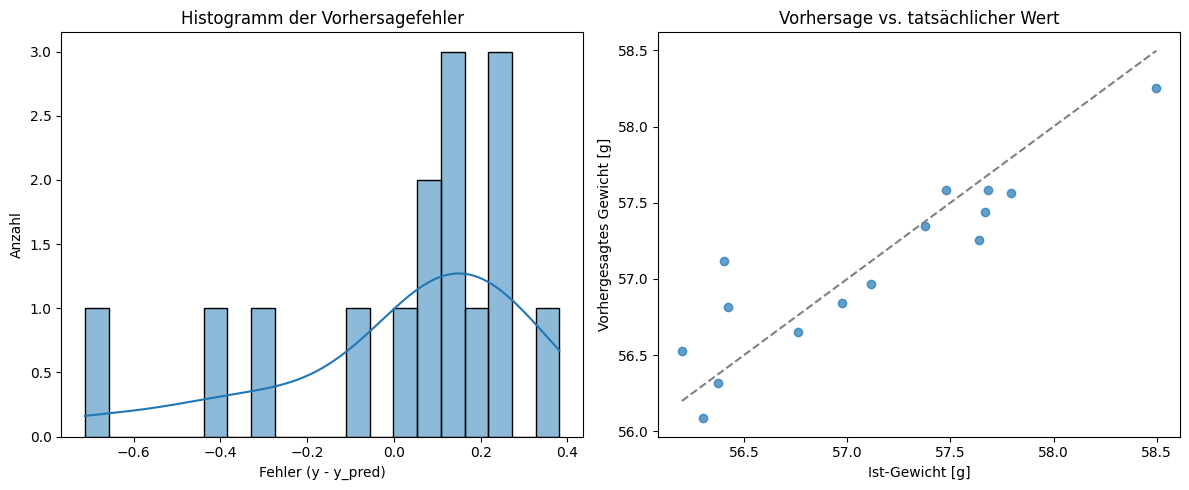

In [56]:
X_test = datasets[best["Feature-Set"]]["X_test"]
y_test = datasets[best["Feature-Set"]]["y_test"]
y_pred = best_model.predict(X_test)
errors = y_test - y_pred

plt.figure(figsize=(12, 5))

# Fehlerverteilung
plt.subplot(1, 2, 1)
sns.histplot(errors, bins=20, kde=True)
plt.title("Histogramm der Vorhersagefehler")
plt.xlabel("Fehler (y - y_pred)")
plt.ylabel("Anzahl")

# Scatterplot y vs y_pred
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "--", color="gray")
plt.title("Vorhersage vs. tatsächlicher Wert")
plt.xlabel("Ist-Gewicht [g]")
plt.ylabel("Vorhergesagtes Gewicht [g]")

plt.tight_layout()
plt.show()

### Vorhersage für unbekannte Daten (`X.csv`)

Abschließend wird das beste Modell verwendet, um auf Basis der gegebenen `X.csv`-Daten  
das finale Flaschengewicht vorherzusagen. Die Ergebnisse werden in `reg_Czermak-Eckstein-Neuner.csv` gespeichert.

In [58]:
X_unseen = pd.read_csv(x_csv_path)

# Nur die benötigten Features des besten Modells extrahieren
X_selected = X_unseen[best_features].copy()

# Bei Bedarf: fill_levels behandeln (falls 0en enthalten)
for col in X_selected.columns:
    if "fill_level" in col:
        mean_val = df[col].replace(0, np.nan).mean()
        X_selected[col] = X_selected[col].replace(0, np.nan).fillna(mean_val)

# Vorhersage
y_pred_unseen = best_model.predict(X_selected)

# Ergebnis als DataFrame
df_pred = pd.DataFrame({
    "bottle": X_unseen["bottle"] if "bottle" in X_unseen.columns else np.arange(len(y_pred_unseen)),
    "predicted_weight": y_pred_unseen
})

# Speichern
df_pred.to_csv(prediction_output_path, index=False)

print(f"Vorhersagen erfolgreich gespeichert unter: {prediction_output_path}")
display(df_pred.head())

Vorhersagen erfolgreich gespeichert unter: c:\Users\maxec\Documents\Studium\4. Semester\Automatisierungstechnik\AUT_IoT_PaToMa\regression\reg_Czermak-Eckstein-Neuner.csv


,bottle,predicted_weight
0,368,50.444209
1,369,48.835893
2,370,49.158162
3,371,34.450060
4,372,33.838944


### Fazit

In dieser Aufgabe wurde erfolgreich ein lineares Regressionsmodell entwickelt,  
das das Endgewicht von Flaschen auf Basis verschiedener Sensorsignale vorhersagt.

Nach dem Vergleich diverser Feature-Sets zeigte sich,  
dass die Vibrationen des Dispensers im linearen Regressionsmodell die stärkste Korrelation mit dem finalen Gewicht aufweisen  
und die besten Vorhersageergebnisse liefern.

Die Modellformel erlaubt eine einfache Interpretation der Einflussfaktoren und wurde im Detail ausgegeben.  
Die finale Vorhersage wurde wie gefordert auf die `X.csv`-Daten angewandt und als `reg_Czermak-Eckstein-Neuner.csv` gespeichert.